In [2]:
import numpy as np
import pandas as pd

from datetime import datetime, date
import time
import pickle

In [6]:
! pip install openturns

    100% |████████████████████████████████| 80.2MB 549kB/s ta 0:00:011


In [3]:
import openturns as ot

In [6]:
# Define Comartment names
compartments = ['Susceptible', 'Exposed', 'Carrier', 'Infected', 'Hospitalized', 'ICU', 'Recovered', 'Dead']
# Define age Groups
groups = ['0-4', '5-14', '15-34', '35-59', '60-79', '80+']
# Define population of age groups
populations = [40000, 70000, 190000, 290000, 180000, 60000] 

days = 100 # number of days to simulate
start_day = 18
start_month = 3
start_year = 2020
starting_day = (date(start_year, start_month, start_day) - date(start_year, 1, 1)).days
dt = 0.1
num_groups = len(groups)
num_compartments = len(compartments)


# define input factors and their distributions
# todo max_rist_of_infection_from symptomatic -> twice rist_of_infection...

params_not_age_dependent = [
    "dummy",
    "incubation_time", 
    "serial_interval", 
    "infectious_mild_time", 
    "hospitalized_to_ICU_time", 
    "risk_of_infection_from_symptomatic",
    "max_risk_of_infection_from_symptomatic",
    "seasonality",
    "test_and_trace_capacity" # multiplier of #tnt_capacity = np.sum(populations)*100.0/100000*(10.0/7)
]


params_not_age_dependent_category = [
    "helper",
    "virus related", 
    "virus related", 
    "transition time", 
    "transition time", 
    "virus related",
    "virus related",
    "virus related",
    "NPI related"
]

params_not_age_dependent_short = [
    "d",
    r"$t_{\textnormal{inc}}$",
    r"$t_{\textnormal{serint}}$",
    r"$T_I^R$",
    r"$T_H^U$", 
    r"$\tilde{\beta}_{I, \textnormal{min}}$",
    r"$\tilde{\beta}_{I, \textnormal{max}}$",
    r"k",
    "cap",
]

dist_not_age_dependent = [
    ot.Uniform(0, 1),
    ot.Uniform(4.1, 7.0), # before 5.2
    ot.Uniform(0.63, 0.87), #0.5 * 2.67 + 0.5 * 5.2; 0.5 * 4.00 + 0.5 * 5.2; before (3.935, 4.6)
    ot.Uniform(5.6, 8.4), 
    ot.Uniform(3, 7),  
    ot.Uniform(0.1, 0.3), 
    ot.Uniform(0.3, 0.5), 
    ot.Uniform(-0.3, 0.3), 
    ot.Uniform(0.8, 1.2)
]

params_damping = [
    'NPI_strength_home',
    'NPI_strength_school',
    'NPI_strength_work',
    'NPI_strength_other',
    #
    'NPI_start_day_home',
    'NPI_start_day_school',
    'NPI_start_day_work',
    'NPI_start_day_other',
]

params_damping_category = ["NPI related"]*len(params_damping)

params_damping_short = [
    r'$r_{\text{home}}$',
    r'$r_{\text{school}}$',
    r'$r_{\text{work}}$',
    r'$r_{\text{other}}$',
    #
    r'$t_{\text{home}}^r$',
    r'$t_{\text{school}}^r$',
    r'$t_{\text{work}}^r$',
    r'$t_{\text{other}}^r$',
]

dist_damping = [
    ot.Uniform(0.0, 1.0),
    ot.Uniform(0.0, 1.0),
    ot.Uniform(0.0, 1.0),
    ot.Uniform(0.0, 1.0),
    #
    ot.Uniform(0.0, days),
    ot.Uniform(0.0, days),
    ot.Uniform(0.0, days),
    ot.Uniform(0.0, days),
]

params_transition_duration = [   
    "hospitalized_to_home_time", 
    "home_to_hospitalized_time",
    "ICU_to_home_time", 
    "ICU_to_death_time"
]
params_transition_duration_short = [      
    r"$T_H^R$", 
    r"$T_I^H$",    
    r"$T_U^R$", 
    r"$T_U^D$",
]

params_transition_duration_ages = [s + f"_{i}" for s in params_transition_duration for i in range(len(groups))]

params_transition_duration_ages_short = [s  for s in params_transition_duration_short for i in range(len(groups))]

params_transition_duration_ages_category = ["transition time"]*len(params_transition_duration_ages)



dist_transition_duration_ages = [ 
    # distributions of the parameters given in params_transition_duration list, one line contains the six age groups
    ot.Uniform(4, 6), ot.Uniform(4, 6), ot.Uniform(5, 7), ot.Uniform(7, 9), ot.Uniform(9, 11), ot.Uniform(13, 17),
    ot.Uniform(9, 12), ot.Uniform(9, 12), ot.Uniform(9, 12), ot.Uniform(5, 7), ot.Uniform(5, 7), ot.Uniform(5, 7),
    ot.Uniform(5, 9), ot.Uniform(5, 9), ot.Uniform(5, 9), ot.Uniform(14, 21), ot.Uniform(14, 21), ot.Uniform(10, 15),
    ot.Uniform(4, 8), ot.Uniform(4, 8), ot.Uniform(4, 8), ot.Uniform(15, 18), ot.Uniform(15, 18), ot.Uniform(10, 12)
]

# only needed for parameter estimation and if the dataset starts after the beginning of the dynamics
initial_numbers_comp = [
    "init_exposed", 
    "init_carrier", 
    "init_infected", 
    #"init_hospitalized", 
    #"init_ICU", 
    #"init_recovered",
    #"init_dead"
]

initial_numbers_comp_category = ["initial value"]*len(initial_numbers_comp)

initial_numbers_comp_short = [
    r"$\text{init}_E$", 
    r"$\text{init}_C$", 
    r"$\text{init}_I$", 
    #"init_hospitalized", 
    #"init_ICU", 
    #"init_recovered",
    #"init_dead"
]

dist_initial_numbers_comp = [
    ot.Uniform(0, 200), 
    ot.Uniform(0, 200), 
    ot.Uniform(120, 130),  
    #ot.Uniform(0, 1),
    #ot.Uniform(0, 1),
    #ot.Uniform(0, 0.1),
    #ot.Uniform(0, 0.001)
]

params_transition_probabilities = [ 
    "infection_probability_from_contact", 
    "relative_carrier_infectability",
    "asymptotic_cases_per_infectious", 
    "hospitalized_cases_per_infectious", 
    "ICU_cases_per_hospitalized",
    "deaths_per_ICU", 
]

params_transition_probabilities_ages = [s + f"_{i}" for s in params_transition_probabilities for i in range(len(groups))]

params_transition_probabilities_ages_category = ["transition probability"]*len(params_transition_probabilities_ages)
params_transition_probabilities_short = [  
    r"$\rho$", 
    r"$\tilde{\beta}_C$",
    r"$\mu_C^R$", 
    r"$\mu_I^H$", 
    r"$\mu_H^U$",
    r"$\mu_U^D$", 
]
params_transition_probabilities_ages_short = [s for s in params_transition_probabilities_short for i in range(len(groups))]

#print(params_transition_probabilities_ages_short)

dist_transition_probabilities_ages = [
    ot.Uniform(0.02, 0.04), ot.Uniform(0.05, 0.07), ot.Uniform(0.05, 0.07), ot.Uniform(0.05, 0.07), ot.Uniform(0.08, 0.1), ot.Uniform(0.15, 0.2),
    ot.Uniform(0.5, 1.5), ot.Uniform(0.5, 1.5), ot.Uniform(0.5, 1.5), ot.Uniform(0.5, 1.5), ot.Uniform(0.5, 1.5), ot.Uniform(0.5, 1.5),
    ot.Uniform(0.2, 0.3), ot.Uniform(0.2, 0.3), ot.Uniform(0.15, 0.25), ot.Uniform(0.15, 0.25), ot.Uniform(0.15, 0.25), ot.Uniform(0.15, 0.25),
    ot.Uniform(0.006, 0.009), ot.Uniform(0.006, 0.009), ot.Uniform(0.015, 0.023), ot.Uniform(0.049, 0.074), ot.Uniform(0.15, 0.18), ot.Uniform(0.2, 0.25),
    ot.Uniform(0.05, 0.1), ot.Uniform(0.05, 0.1), ot.Uniform(0.05, 0.1), ot.Uniform(0.1, 0.2), ot.Uniform(0.25, 0.35), ot.Uniform(0.35, 0.45),
    ot.Uniform(0.0, 0.1), ot.Uniform(0.0, 0.1), ot.Uniform(0.1, 0.18), ot.Uniform(0.1, 0.18), ot.Uniform(0.3, 0.5), ot.Uniform(0.5, 0.7),
]

input_factor_names = params_not_age_dependent \
                    + params_damping \
                    + params_transition_duration_ages \
                    + params_transition_probabilities_ages \
                    + initial_numbers_comp

input_factor_names_short = params_not_age_dependent_short \
                    + params_damping_short \
                    + params_transition_duration_ages_short \
                    + params_transition_probabilities_ages_short \
                    + initial_numbers_comp_short

age_dep = [False for i in params_not_age_dependent] \
                    + [False for i in params_damping] \
                    + [True for i in params_transition_duration_ages] \
                    + [True for i in params_transition_probabilities_ages] \
                    + [False for i in initial_numbers_comp]

categories = params_not_age_dependent_category \
            + params_damping_category \
            + params_transition_duration_ages_category \
            + params_transition_probabilities_ages_category \
            + initial_numbers_comp_category

print(len(input_factor_names))

distributions = dist_not_age_dependent \
    + dist_damping \
    + dist_transition_duration_ages \
    + dist_transition_probabilities_ages \
    + dist_initial_numbers_comp

name_dict = dict(zip(input_factor_names,input_factor_names_short))
name_dict

80


{'dummy': 'd',
 'incubation_time': '$t_{\\textnormal{inc}}$',
 'serial_interval': '$t_{\\textnormal{serint}}$',
 'infectious_mild_time': '$T_I^R$',
 'hospitalized_to_ICU_time': '$T_H^U$',
 'risk_of_infection_from_symptomatic': '$\\tilde{\\beta}_{I, \\textnormal{min}}$',
 'max_risk_of_infection_from_symptomatic': '$\\tilde{\\beta}_{I, \\textnormal{max}}$',
 'seasonality': 'k',
 'test_and_trace_capacity': 'cap',
 'NPI_strength_home': '$r_{\\text{home}}$',
 'NPI_strength_school': '$r_{\\text{school}}$',
 'NPI_strength_work': '$r_{\\text{work}}$',
 'NPI_strength_other': '$r_{\\text{other}}$',
 'NPI_start_day_home': '$t_{\\text{home}}^r$',
 'NPI_start_day_school': '$t_{\\text{school}}^r$',
 'NPI_start_day_work': '$t_{\\text{work}}^r$',
 'NPI_start_day_other': '$t_{\\text{other}}^r$',
 'hospitalized_to_home_time_0': '$T_H^R$',
 'hospitalized_to_home_time_1': '$T_H^R$',
 'hospitalized_to_home_time_2': '$T_H^R$',
 'hospitalized_to_home_time_3': '$T_H^R$',
 'hospitalized_to_home_time_4': '$T_H^

In [7]:
group_list = np.zeros(len(input_factor_names))
group_names = [
    # compartment_dependent
    "init", 
    # location dependent
    "NPI_strength",
    "NPI_start",
    # age dependent
    "hospitalized_to_home_time",
    "home_to_hospitalized_time",
    "ICU_to_home_time",
    "ICU_to_death_time",
    "infection_probability_from_contact",
    "relative_carrier_infectability",
    "asymptotic_cases_per_infectious",
    "hospitalized_cases_per_infectious",
    "ICU_cases_per_hospitalized",
    "deaths_per_ICU",
    # other parameters
    'dummy',
    'incubation_time',
    'serial_interval',
    'infectious_mild_time',
    'hospitalized_to_ICU_time',
    'risk_of_infection_from_symptomatic',
    'seasonality',
    'test_and_trace_capacity'
]   

compartment = ["initial_infections"]
location = [
    "NPI_strength",
    "NPI_start",]
age = [
      "hospitalized_to_home_time",
    "home_to_hospitalized_time",
    "ICU_to_home_time",
    "ICU_to_death_time",
    "infection_probability_from_contact",
    "relative_carrier_infectability",
    "asymptotic_cases_per_infectious",
    "hospitalized_cases_per_infectious",
    "ICU_cases_per_hospitalized",
    "deaths_per_ICU",  
    ]
other = [
    'dummy',
    'incubation_time',
    'serial_interval',
    'infectious_mild_time',
    'hospitalized_to_ICU_time',
    'risk_of_infection_from_symptomatic',
    'seasonality', 
    'test_and_trace_capacity'
    ]      

group_ids = dict(zip(group_names, range(len(group_names))))
#print(group_ids)
groups = [name for factor_name in input_factor_names for name in group_names if (name in factor_name) ]
#print(groups)
#print(len(groups))

# factor is in which group
group_dict = {}
for i in range(len(input_factor_names)):
    group_dict[input_factor_names[i]] = groups[i]
    
problem = {  
    'names': input_factor_names,
    'bounds': [[distributions[i].getA(), distributions[i].getB()] for i in range(len(input_factor_names))]}

In [ ]:
category = {"inital value":, 
            "transition time":, 
            "transition probability":, 
            "virus related":, 
            "contact related":,
            "helper":} 

In [9]:
df = pd.DataFrame({"Name": input_factor_names, 
                   "Short": input_factor_names_short, 
                   "ot dist": distributions, 
                   'bounds': [[distributions[i].getA(), distributions[i].getB()] for i in range(len(input_factor_names))],
                   "Age-dep": age_dep, 
                   "Group": [group_dict[name] for name in input_factor_names],
                   "Category": categories
                  })
df.loc[:20]

,Name,Short,ot dist,bounds,Age-dep,Group,Category
0,dummy,d,"Uniform(a = 0, b = 1)","[0.0, 1.0]",False,dummy,helper
1,incubation_time,$t_{\textnormal{inc}}$,"Uniform(a = 4.1, b = 7)","[4.1, 7.0]",False,incubation_time,virus related
2,serial_interval,$t_{\textnormal{serint}}$,"Uniform(a = 0.63, b = 0.87)","[0.63, 0.87]",False,serial_interval,virus related
3,infectious_mild_time,$T_I^R$,"Uniform(a = 5.6, b = 8.4)","[5.6, 8.4]",False,infectious_mild_time,transition time
4,hospitalized_to_ICU_time,$T_H^U$,"Uniform(a = 3, b = 7)","[3.0, 7.0]",False,hospitalized_to_ICU_time,transition time
5,risk_of_infection_from_symptomatic,"$\tilde{\beta}_{I, \textnormal{min}}$","Uniform(a = 0.1, b = 0.3)","[0.1, 0.3]",False,risk_of_infection_from_symptomatic,virus related
6,max_risk_of_infection_from_symptomatic,"$\tilde{\beta}_{I, \textnormal{max}}$","Uniform(a = 0.3, b = 0.5)","[0.3, 0.5]",False,risk_of_infection_from_symptomatic,virus related
7,seasonality,k,"Uniform(a = -0.3, b = 0.3)","[-0.3, 0.3]",False,seasonality,virus related
8,test_and_trace_capacity,cap,"Uniform(a = 0.8, b = 1.2)","[0.8, 1.2]",False,test_and_trace_capacity,NPI related
9,NPI_strength_home,$r_{\text{home}}$,"Uniform(a = 0, b = 1)","[0.0, 1.0]",False,NPI_strength,NPI related


In [20]:
df = df.sort_values(["Category", "Age-dep", "Name"], ignore_index = True, ascending = False)
df

,Name,Short,ot dist,bounds,Age-dep,Group,Category
0,serial_interval,$t_{\textnormal{serint}}$,"Uniform(a = 0.63, b = 0.87)","[0.63, 0.87]",False,serial_interval,virus related
1,seasonality,k,"Uniform(a = -0.3, b = 0.3)","[-0.3, 0.3]",False,seasonality,virus related
2,risk_of_infection_from_symptomatic,"$\tilde{\beta}_{I, \textnormal{min}}$","Uniform(a = 0.1, b = 0.3)","[0.1, 0.3]",False,risk_of_infection_from_symptomatic,virus related
3,max_risk_of_infection_from_symptomatic,"$\tilde{\beta}_{I, \textnormal{max}}$","Uniform(a = 0.3, b = 0.5)","[0.3, 0.5]",False,risk_of_infection_from_symptomatic,virus related
4,incubation_time,$t_{\textnormal{inc}}$,"Uniform(a = 4.1, b = 7)","[4.1, 7.0]",False,incubation_time,virus related
...,...,...,...,...,...,...,...
75,NPI_strength_home,$r_{\text{home}}$,"Uniform(a = 0, b = 1)","[0.0, 1.0]",False,NPI_strength,NPI related
76,NPI_start_day_work,$t_{\text{work}}^r$,"Uniform(a = 0, b = 100)","[0.0, 100.0]",False,NPI_start,NPI related
77,NPI_start_day_school,$t_{\text{school}}^r$,"Uniform(a = 0, b = 100)","[0.0, 100.0]",False,NPI_start,NPI related
78,NPI_start_day_other,$t_{\text{other}}^r$,"Uniform(a = 0, b = 100)","[0.0, 100.0]",False,NPI_start,NPI related


In [21]:
already_seen = []
for i in range(len(df)):
    if not df.loc[i]['Age-dep']:
        name = df.loc[i]['Name'].replace("_", " ")
        short = df.loc[i]['Short']
        bounds = df.loc[i]['bounds']
        print(f"{short} & {name} & & \multicolumn \u007b6\u007d {{c}}\u007b{bounds}\u007d \u005c\u005c" )
    else:
        if df.loc[i]['Group'] not in already_seen:
            name = df.loc[i]['Group'].replace("_", " ")
            short = df.loc[i]['Short']
            bounds = ''.join(f"& {interval} " for interval in list(df[df["Group"] == df.loc[i]['Group']]['bounds'].values) )
            print(f"{short} & {name} & {bounds} \u005c\u005c" )
            already_seen.append(df.loc[i]['Group'])

$t_{\textnormal{serint}}$ & serial interval & & \multicolumn {6} {c}{[0.63, 0.87]} \\
k & seasonality & & \multicolumn {6} {c}{[-0.3, 0.3]} \\
$\tilde{\beta}_{I, \textnormal{min}}$ & risk of infection from symptomatic & & \multicolumn {6} {c}{[0.1, 0.3]} \\
$\tilde{\beta}_{I, \textnormal{max}}$ & max risk of infection from symptomatic & & \multicolumn {6} {c}{[0.3, 0.5]} \\
$t_{\textnormal{inc}}$ & incubation time & & \multicolumn {6} {c}{[4.1, 7.0]} \\
$T_H^R$ & hospitalized to home time & & [13.0, 17.0] & [9.0, 11.0] & [7.0, 9.0] & [5.0, 7.0] & [4.0, 6.0] & [4.0, 6.0]  \\
$T_I^H$ & home to hospitalized time & & [5.0, 7.0] & [5.0, 7.0] & [5.0, 7.0] & [9.0, 12.0] & [9.0, 12.0] & [9.0, 12.0]  \\
$T_U^R$ & ICU to home time & & [10.0, 15.0] & [14.0, 21.0] & [14.0, 21.0] & [5.0, 9.0] & [5.0, 9.0] & [5.0, 9.0]  \\
$T_U^D$ & ICU to death time & & [10.0, 12.0] & [15.0, 18.0] & [15.0, 18.0] & [4.0, 8.0] & [4.0, 8.0] & [4.0, 8.0]  \\
$T_I^R$ & infectious mild time & & \multicolumn {6} {c}{[5.6,

In [54]:
df.loc[0]

Name                       dummy
Short                      dummy
ot dist    Uniform(a = 0, b = 1)
bounds                [0.0, 1.0]
Age-dep                    False
Group                      dummy
Name: 0, dtype: object

In [52]:
len(df)

80

In [78]:
chr('{')

TypeError: an integer is required (got type str)

In [2]:
import numpy as np

In [3]:
N = 3
num_resamples = 10
rng = np.random.randint
r = rng(N, size=(N, num_resamples))
print(r)

[[1 1 1 2 2 2 0 2 1 2]
 [1 0 2 0 1 2 0 0 0 1]
 [1 1 2 2 1 2 0 0 0 1]]


In [11]:
k = 7
A = np.random.randint(4, 9, size=(N, k))
A

array([[6, 6, 8, 8, 8, 6, 6],
       [4, 6, 4, 7, 8, 8, 5],
       [5, 8, 7, 8, 4, 6, 4]])

In [12]:
A[r]

array([[[4, 6, 4, 7, 8, 8, 5],
        [4, 6, 4, 7, 8, 8, 5],
        [4, 6, 4, 7, 8, 8, 5],
        [5, 8, 7, 8, 4, 6, 4],
        [5, 8, 7, 8, 4, 6, 4],
        [5, 8, 7, 8, 4, 6, 4],
        [6, 6, 8, 8, 8, 6, 6],
        [5, 8, 7, 8, 4, 6, 4],
        [4, 6, 4, 7, 8, 8, 5],
        [5, 8, 7, 8, 4, 6, 4]],

       [[4, 6, 4, 7, 8, 8, 5],
        [6, 6, 8, 8, 8, 6, 6],
        [5, 8, 7, 8, 4, 6, 4],
        [6, 6, 8, 8, 8, 6, 6],
        [4, 6, 4, 7, 8, 8, 5],
        [5, 8, 7, 8, 4, 6, 4],
        [6, 6, 8, 8, 8, 6, 6],
        [6, 6, 8, 8, 8, 6, 6],
        [6, 6, 8, 8, 8, 6, 6],
        [4, 6, 4, 7, 8, 8, 5]],

       [[4, 6, 4, 7, 8, 8, 5],
        [4, 6, 4, 7, 8, 8, 5],
        [5, 8, 7, 8, 4, 6, 4],
        [5, 8, 7, 8, 4, 6, 4],
        [4, 6, 4, 7, 8, 8, 5],
        [5, 8, 7, 8, 4, 6, 4],
        [6, 6, 8, 8, 8, 6, 6],
        [6, 6, 8, 8, 8, 6, 6],
        [6, 6, 8, 8, 8, 6, 6],
        [4, 6, 4, 7, 8, 8, 5]]])

In [22]:
!pip install SALib

    100% |████████████████████████████████| 757kB 1.7MB/s ta 0:00:01
    100% |████████████████████████████████| 81kB 1.4MB/s ta 0:00:01
    100% |████████████████████████████████| 71kB 2.8MB/s ta 0:00:01
    100% |████████████████████████████████| 92kB 1.5MB/s ta 0:00:01
    100% |████████████████████████████████| 112kB 2.3MB/s ta 0:00:01
  Found existing installation: dill 0.2.9
    Uninstalling dill-0.2.9:
      Successfully uninstalled dill-0.2.9


In [24]:
from SALib.sample import sobol_sequence

In [48]:
import matplotlib.pyplot as plt

In [54]:
N = 50
d = 5
seq = sobol_sequence.sample(N*2+1, d)
for i in np.arange(N,seq.shape[0]):
    print( ' & '.join(f"{seq[i, j]}" for j in range(seq.shape[1]) )+"  \u005c\u005c" )

0.828125 & 0.484375 & 0.546875 & 0.390625 & 0.671875  \\
0.328125 & 0.984375 & 0.046875 & 0.890625 & 0.171875  \\
0.453125 & 0.359375 & 0.421875 & 0.765625 & 0.046875  \\
0.953125 & 0.859375 & 0.921875 & 0.265625 & 0.546875  \\
0.703125 & 0.109375 & 0.171875 & 0.515625 & 0.796875  \\
0.203125 & 0.609375 & 0.671875 & 0.015625 & 0.296875  \\
0.140625 & 0.421875 & 0.234375 & 0.328125 & 0.984375  \\
0.640625 & 0.921875 & 0.734375 & 0.828125 & 0.484375  \\
0.890625 & 0.171875 & 0.484375 & 0.078125 & 0.234375  \\
0.390625 & 0.671875 & 0.984375 & 0.578125 & 0.734375  \\
0.265625 & 0.046875 & 0.609375 & 0.703125 & 0.609375  \\
0.765625 & 0.546875 & 0.109375 & 0.203125 & 0.109375  \\
0.515625 & 0.296875 & 0.859375 & 0.953125 & 0.359375  \\
0.015625 & 0.796875 & 0.359375 & 0.453125 & 0.859375  \\
0.0234375 & 0.3984375 & 0.8203125 & 0.8359375 & 0.6484375  \\
0.5234375 & 0.8984375 & 0.3203125 & 0.3359375 & 0.1484375  \\
0.7734375 & 0.1484375 & 0.5703125 & 0.5859375 & 0.3984375  \\
0.2734375 & 0.64

In [145]:
N = 2**3
skip = 2**5
d = 40
seq = sobol_sequence.sample(skip + N, d)

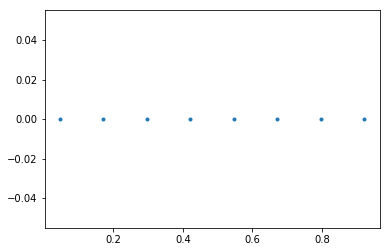

In [146]:
plt.plot(seq[skip:, 0], np.zeros(N), '.')

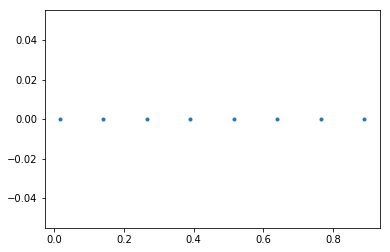

In [148]:
plt.plot(seq[skip:, -4], np.zeros(N) , '.')

In [64]:
seq[:, -1].shape

(201,)